# Classify TF binding

**Prénom**: Alexandre \
**Nom**: Devaux Riviere \
**Login**: alexandre.devaux-riviere

In [1]:
import joblib
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

# Ex1: Onehot coding DNA

Write a function called **onehot_dna(dna_str)** that allows to encode a DNA segment where each base is encoded as a vector of all zeros except one in a specific position. The result of this function is an array numpy.  DNA is a long chain of repeating bases strung together. There are 4 bases: A, C, G, T. For example, "AACCCAAATCGGGGG" is a DNA segment.



For example, **onehot_dna('AAT')** should return

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])






In [2]:
def onehot_dna(dna_str):
    dna_map = {
        'A': [1,0,0,0],
        'C': [0,1,0,0],
        'G': [0,0,1,0],
        'T': [0,0,0,1]
    }
    return np.array([dna_map[base] for base in dna_str])

In [3]:
onehot_dna('AAT')

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1]])

In [4]:
onehot_dna('AATTCGAGGT')

array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 1, 0, 0],
       [0, 0, 1, 0],
       [1, 0, 0, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 0, 1]])

# Deep learning to classify Transcription Factor Biding


In the next exercises, we will learn how to use Deep learning to predict whether a segment of DNA does include or does not include a sit where JUND binds. (JUND is a particular transcription factor).

In this purpose, we will use data that is extracted from the chapter 6 of the book: 'Deep learning for the life science'. This book is written by B.Ramsundar, P.Eastman, P. Walters and V.Pande.



By looking at the Wikipedia page of the Jund transcription factor, explain what is the use of such protein 

**Answer:**

> JUND is a transcription factor protein that belongs to the JUN family. It's a component which is involved in regulating gene expression playing important roles in:

> - Cell proliferation and differentiation
> - Protection against oxidative stress
> - Regulation of cell survival
> - Tumor suppression

> JUND can act as a negative regulator of cell growth, making it interesting in cancer research and cell biology studies.


Data consist of DNA segments that have been split up from a full chromosome. Each segment is of 101 bases long and has been labeled to indicate whether it does or does not include a site where JUND binds to.


This is a binary classification problem.
The process of creating a PyTorch neural network binary classifier consists of several steps:

1. Prepare the training and test data

2. Implement a Dataset object to serve up the data

3. Design and implement a neural network

4. Write code to train the network

5. Write code to evaluate the model (the trained network)


# Ex 2:  Load Data

The data is available here : https://drive.google.com/drive/folders/1-nrTvNvEZo6Px1pnT7IeotKZR7p365UJ?usp=sharing

1. With the help of the joblib library, load the following files for training set:  **y_train.joblib**, **X_train.joblib**  and then store the results in variables **y_train, X_train** ,respectively.

2. Do the same thing for the test set: load  **y_test.joblib**, **X_test.joblib**  and then store the results in variables **y_test, X_test**, respectively.

3. What are the shape of **X_train** and **y_train** ? How many DNA segments are there in traning set ?

4. Display a DNA segment from **X_train** (using matplotlib.pyplot.imshow ).

5. Plot the histogram of **y_train** to see whether data is imbalanced or not.


In [5]:
# 1.1
X_train = joblib.load('data/X_train.joblib')
y_train = joblib.load('data/y_train.joblib')

# 1.2
X_test = joblib.load('data/X_test.joblib')
y_test = joblib.load('data/y_test.joblib')

In [6]:
''' Tests X_train, y_train '''
assert(X_train.shape == (4672, 101, 4))
assert(y_train.shape ==(4672, 1))

''' Tests X_test, y_test'''
assert(X_test.shape == (584, 101, 4))
assert(y_test.shape ==(584, 1))

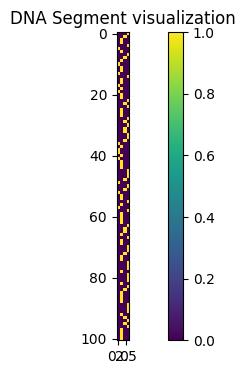

In [7]:
# 1.4
plt.figure(figsize=(10, 4))
plt.imshow(X_train[0])
plt.title('DNA Segment visualization')
plt.colorbar()
plt.show()

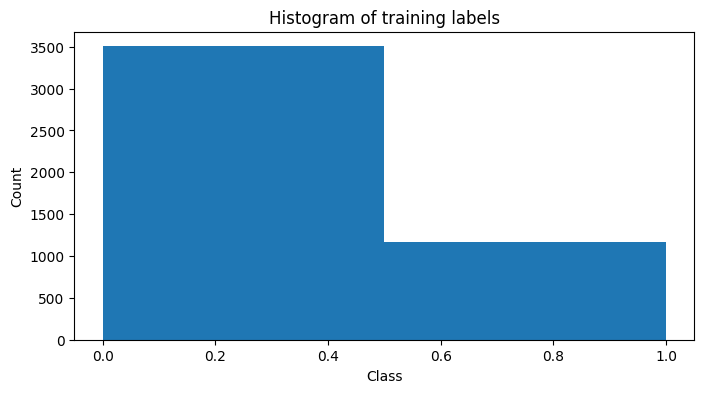

In [8]:
# 1.5
plt.figure(figsize=(8, 4))
plt.hist(y_train, bins=2)
plt.title('Histogram of training labels')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

> We can see that the labels are not balanced.

# Ex 3: Convert numpy array to tensor pytorch

As you see in the previous exercise, **X_train** consists of 4672 segments. Each segment is encoded by 0 and 1 (one-hot encoding).


1. Convert numpy array **X_train**, **y_train** into pytorch tensor. Reshape **X_train** to (4672, 4, 101). Note that the type of **X_train** and **y_train** should be float.

2. Do the same thing for **X_test** and **y_test**


In [9]:
# 3.1
X_train_ts = torch.FloatTensor(X_train).permute(0, 2, 1)
y_train_ts = torch.FloatTensor(y_train)

# 3.2
X_test_ts = torch.FloatTensor(X_test).permute(0, 2, 1)
y_test_ts = torch.FloatTensor(y_test)

In [10]:
''' Tests X_train_ts, y_train_ts '''
assert(type(X_train_ts) is torch.Tensor)
assert(type(y_train_ts) is torch.Tensor)
assert(X_train_ts.shape == (4672, 4, 101))

In [11]:
''' Tests the above ToDo. '''
assert(type(X_test_ts) is torch.Tensor)
assert(type(y_test_ts) is torch.Tensor)
assert(X_test_ts.shape == (584, 4, 101))

# Ex4: Create Dataset
In order to train a deep learning model with Pytorch, we need a pytorch dataset.
The DNADataset class below allows for creating a pytorch Dataset from DNA segments and their labels.

1. Using this class, create a dataset for training set. You should call it **train_dataset**

2. Create **Dataloader** from **train_dataset**. You should call it **train_loader**.

3. Do the same thing for the test set.

In [12]:
class DNADataset(torch.utils.data.Dataset):
    def __init__(self, dna, labels):
        self.labels = labels
        self.dna = dna


    def __len__(self):
        return len(self.labels)


    def __getitem__(self, idx):
        label = self.labels[idx]
        frag_dna = self.dna[idx]

        sample = {'DNA': frag_dna, 'Class': label}
        return sample

In [13]:
# 4.1
train_dataset = DNADataset(X_train_ts, y_train_ts)
test_dataset = DNADataset(X_test_ts, y_test_ts)

# 4.2 / 4.3
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

**train_loader** is a generator. To get data out of it, you need to loop through it or convert it to an iterator and call next()

In [14]:
# Run this to test your data loader
data = next(iter(train_loader))
dna = data['DNA']
label = data['Class']
print("a batch data ", dna.shape)
print("Shape of label", label.shape)

a batch data  torch.Size([32, 4, 101])
Shape of label torch.Size([32, 1])


# Design and implement a convolutional neural network

Now, it's time to build your model. This is a binary classification problem. We can use a convolution neural network, just like an image classification problem. However, since the size of a DNA segment is (4, 101), we will use 1D convolution instead of 2D convolution.



Firstly, we will test how does a 1D convolution work on our data.



# EX 5: 1D Convolution

1. With the help of the torch.nn.Conv1d class, create a 1D convolutional layer. You need to choose values for the following parameters: **in_channels**, **out_channels**, **kernel_size**.


2. Apply this layer to **dna_seg** below. What is the size of the output ?


3. [Optional] Display the output by using matplotlib.pyplot.imshow




In [15]:
# 5.1
conv1d = nn.Conv1d(in_channels=4, out_channels=16, kernel_size=3)
data = next(iter(train_loader))
dna_seg = data['DNA']
y = data['Class']

# 5.2
out_conv = conv1d(dna_seg)
print(f"Conv output shape: {out_conv.shape}")

Conv output shape: torch.Size([32, 16, 99])


# EX 6: Build a model

Create a 3 layer 1-dimensional network to classify the TF binding sites

In [16]:
class DeepDNA(nn.Module):
    def __init__(self, seq_length):
        super(DeepDNA, self).__init__()
        self.conv1 = nn.Conv1d(4, 32, kernel_size=3)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3)
        self.l1 = nn.Linear(128 * (seq_length - 6), 64)
        self.l2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)
        x = F.relu(self.l1(x))
        x = torch.sigmoid(self.l2(x))
        return x

# Ex 7 Test the model


1. Create an instance of the DeepDNA class named **net**.

2. Print out the variable **net** to see detailed information about the model.

3. Pass **dna_seg** below to **net** in order to  test if your model **net** works well.

4. What is the size of the output ?



In [17]:
dna_seg = data['DNA']

# 7.1
net = DeepDNA(101)

# 7.2
print(net)

DeepDNA(
  (conv1): Conv1d(4, 32, kernel_size=(3,), stride=(1,))
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (conv3): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
  (l1): Linear(in_features=12160, out_features=64, bias=True)
  (l2): Linear(in_features=64, out_features=1, bias=True)
)


In [18]:
# 7.3
out = net(dna_seg)

In [19]:
# 7.4
print("the output of the model ", out[:5])

the output of the model  tensor([[0.5286],
        [0.5270],
        [0.5251],
        [0.5281],
        [0.5281]], grad_fn=<SliceBackward0>)


# Ex 8: Define loss function and optimizer


1. Define an SGD optimizer for the model. You need to choose the learning rate for your model.

2. Define a Binary Cross Entropy (BCE) Loss  function.


In [20]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001)

# Ex 9: Training your model

The following function allows to train the model for one epoch. This function returns total loss per epoch.
Implement the training pass for this function.



The general process with PyTorch for one learning step consits of several steps:

1. Make a forward pass through the network
2. Use the network output to calculate the loss
3. Perform a backward pass through the network with loss.backward() to calculate the gradients
4. Take a step with the optimizer to update the weights



In [21]:
def train():
    net.train()
    loss_epoch = 0
    for batch_data in train_loader:
        optimizer.zero_grad()
        dna = batch_data['DNA']
        labels = batch_data['Class']

        # forward
        outputs = net(dna)
        loss = criterion(outputs, labels)

        # backward
        loss.backward()
        optimizer.step()

        loss_epoch += loss.item()

    return loss_epoch

# Ex 11: Accuracy Calculation

Write a function named **compute_num_correct_pred(y_prob, y_label)** that allows to compute the number of correct predictions. **y_prob** and **y_label** should be pytorch tensors.

For example,
y_prob = [[0.3],[0.4], [0.8], [0.7]].

y = [[0], [1], [1], [0]].

This function should return 2.

In [22]:
def compute_num_correct_pred(y_prob, y_label):
    predictions = (y_prob >= 0.5).float()
    return (predictions == y_label).sum().item()


The function below allows to calculate the accuracy of the model on dataset loader. Execute this function to see if you implemented the compute_num_correct_pred function correctly.

In [23]:
def test(loader):
  net.eval()

  correct = 0
  with torch.no_grad():
    for data in loader:
      dna = data['DNA']
      y = data['Class']

      out = net(dna)
      correct += compute_num_correct_pred(out, y)

  return correct / len(loader.dataset)

# Ex 12: Training the model

The code below allows to train your model on 10 epoches. If all work well, you should see the training loss drop with each epoch.

train the model for 2000 epochs

In [24]:
n_epochs = 2000
train_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(n_epochs):
    loss = train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)

    train_losses.append(loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    if (epoch + 1) % 50 == 0:
        print(f'Epoch {epoch+1}/{n_epochs}, train_loss: {loss:.4f}, train_accuracy: {train_acc:.4f}, test_accuracy: {test_acc:.4f}')

Epoch 50/2000, train_loss: 82.0597, train_accuracy: 0.7500, test_accuracy: 0.7500
Epoch 100/2000, train_loss: 81.9419, train_accuracy: 0.7500, test_accuracy: 0.7500
Epoch 150/2000, train_loss: 81.7979, train_accuracy: 0.7500, test_accuracy: 0.7500
Epoch 200/2000, train_loss: 81.6282, train_accuracy: 0.7500, test_accuracy: 0.7500
Epoch 250/2000, train_loss: 81.3882, train_accuracy: 0.7500, test_accuracy: 0.7500
Epoch 300/2000, train_loss: 81.0509, train_accuracy: 0.7500, test_accuracy: 0.7500
Epoch 350/2000, train_loss: 80.5269, train_accuracy: 0.7500, test_accuracy: 0.7500
Epoch 400/2000, train_loss: 79.7580, train_accuracy: 0.7500, test_accuracy: 0.7500
Epoch 450/2000, train_loss: 78.6719, train_accuracy: 0.7500, test_accuracy: 0.7500
Epoch 500/2000, train_loss: 77.3205, train_accuracy: 0.7515, test_accuracy: 0.7483
Epoch 550/2000, train_loss: 75.9889, train_accuracy: 0.7547, test_accuracy: 0.7483
Epoch 600/2000, train_loss: 74.4054, train_accuracy: 0.7573, test_accuracy: 0.7483
Epoch

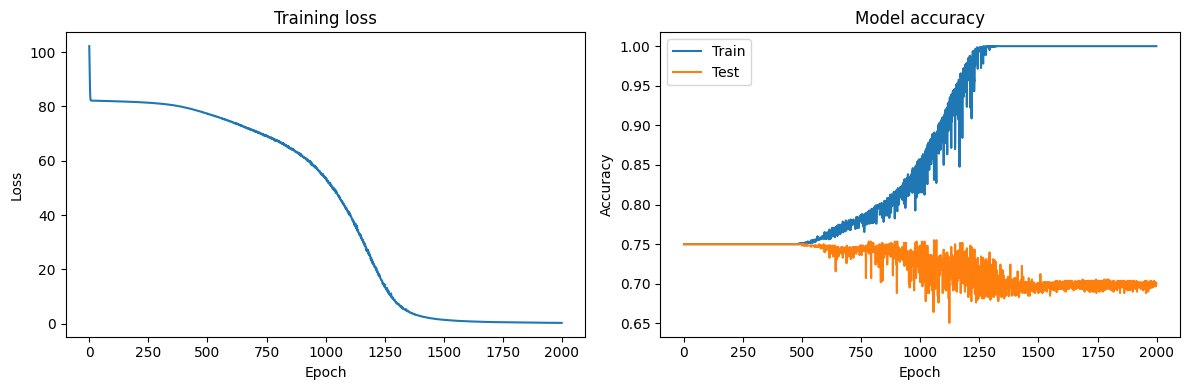

In [26]:
plt.figure(figsize=(12, 4))

# 1
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# 2
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train')
plt.plot(test_accuracies, label='Test')
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

> We can see that the model is overfitting due to the facts that the loss is very low, the training accuracy is 1.0 and the validation loss is decreasing. Training this model takes too much time, I don't have the time to try other configuration but adding dropout and weight decay could be a good start to find a good solution to this problem.

# Ex13 (optional)



1. If we use torch.nn.BCEWithLogitsLoss(), what does we need to change to the definition of the model ?



2. The same question for torch.nn.CrossEntropyLoss() loss.  